# Лабораторная работа 6
## Анализ и прогнозирование временного ряда.
Цель лабораторной работы: изучение основных методов анализа и прогнозирование временных рядов.

Задание:
Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
Визуализируйте временной ряд и его основные характеристики.
Разделите временной ряд на обучающую и тестовую выборку.
Произведите прогнозирование временного ряда с использованием как минимум двух методов.
Визуализируйте тестовую выборку и каждый из прогнозов.
Оцените качество прогноза в каждом случае с помощью метрик.

In [1]:
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv', sep=',')
data

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


Предварительная обработка

Удаляем столбцы с пустыми значениями:

In [3]:
data = data.dropna(axis=1, how='any')
data

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


In [4]:
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq(freq ='MS')
data = data.sort_index()
data

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


## Разделение выборки на обучающую и тестовую

                   y    exog_1    exog_2
date                                    
1992-04-01  0.379808  0.958792  1.166029
1992-05-01  0.361801  0.951993  1.117859
1992-06-01  0.410534  0.952955  1.067942
1992-07-01  0.483389  0.958078  1.097376
1992-08-01  0.475463  0.956370  1.122199
...              ...       ...       ...
2008-02-01  0.761822  1.515840  1.786373
2008-03-01  0.649435  1.506258  1.694264
2008-04-01  0.827887  1.505253  1.627135
2008-05-01  0.816255  1.491464  1.555068
2008-06-01  0.762137  1.459856  1.463507

[195 rows x 3 columns]
Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


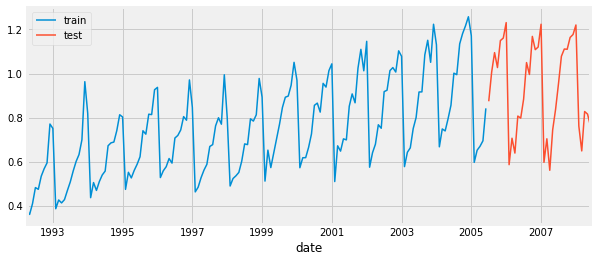

In [5]:
import matplotlib.pyplot as plt
steps = 36
# scaler = MinMaxScaler().fit(data_train[['open']])

# data['open'] = scaler.transform(data[['open']])
data_train = data[:-steps]
data_test  = data[-steps:]
print(data)


print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score

def test_model(predictions):
    print('mean_absolute_error: {}'.format(round(mean_absolute_error(data_test['y'], predictions), 2)))
    print('median_absolute_error: {}'.format(round(median_absolute_error(data_test['y'], predictions), 2)))
    print('r2_score: {}'.format(round(r2_score(data_test['y'], predictions), 2)))

## Обучение моделей

### Skforecast-ForecasterAutoreg

In [7]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['y'])
forecaster
steps = 36
predictions = forecaster.predict(steps=steps)


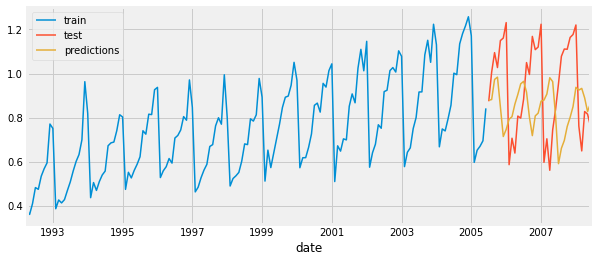

In [8]:
fig, ax2 = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax2, label='train')
data_test['y'].plot(ax=ax2, label='test')
predictions.plot(ax=ax2, label='predictions')
ax2.legend();

In [9]:
lags_grid = [10, 16]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:32<00:00, 16.31s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.012757579470218128



mean_absolute_error: 0.06
median_absolute_error: 0.06
r2_score: 0.88


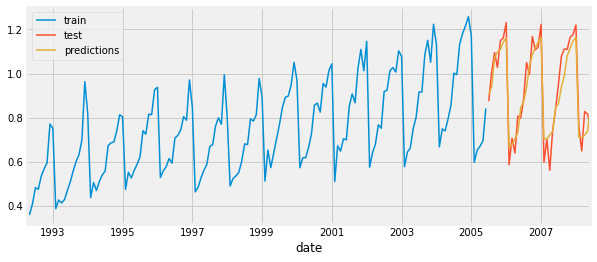

In [10]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 16
             )

forecaster.fit(y=data_train['y'])
predictions = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
test_model(predictions)

### SARIMAX

C:\Users\ksush\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mean_absolute_error: 0.06
median_absolute_error: 0.05
r2_score: 0.87


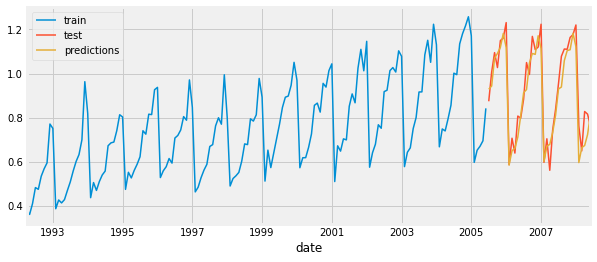

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
SARIMAXmodel = SARIMAX(data_train['y'], order = (2, 1, 2), seasonal_order=(2,1,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"]
fig, ax2 = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax2, label='train')
data_test['y'].plot(ax=ax2, label='test')
y_pred_out.plot(ax=ax2, label='predictions')
ax2.legend()
test_model(y_pred_out)